In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import os
import tarfile
from collections import OrderedDict
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import random
import argparse # Needed to load the checkpoint

# Scikit-learn (for FINAL evaluation)
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns



In [34]:
# Set CUDA to run synchronously for better error messages
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.5.1
CUDA available: True


In [35]:
# --- 1. Define Paths ---
DATASET_PATH = "." 
TRAIN_LIST_FILE = os.path.join(DATASET_PATH, "list/train.txt")
TEST_LIST_FILE = os.path.join(DATASET_PATH, "list/test.txt")
TEST_TRUTH_FILE = os.path.join(DATASET_PATH, "list/groundtruth.txt")
WITH_PAIRS_FILE = os.path.join(DATASET_PATH, "list/class_with_pairs.txt")
WITHOUT_PAIRS_FILE = os.path.join(DATASET_PATH, "list/class_without_pairs.txt")
TRAIN_IMG_DIR = DATASET_PATH
TEST_IMG_DIR = DATASET_PATH

# Path to save our best models
BEST_BACKBONE_PATH = "triplet_backbone_best_F_1.pth" # From Triplet Loss training
BEST_CLASSIFIER_PATH = "triplet_classifier_best_F_1.pth" # From Classifier training

# --- 2. Define Hyperparameters ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 100
VAL_SPLIT = 0.2 
BATCH_SIZE = 16 # Triplet loss uses more memory, so a smaller batch is safer
LEARNING_RATE_BACKBONE = 1e-5 # Very small LR for fine-tuning the backbone
LEARNING_RATE_HEAD = 1e-3 # Standard LR for training the new head
NUM_EPOCHS_BACKBONE = 20 # Epochs to train the backbone
NUM_EPOCHS_HEAD = 20 # Epochs to train the head
MARGIN = 0.2 # Triplet loss margin

print(f"Using device: {DEVICE}")

Using device: cuda


In [36]:
print("Building label map...")
train_labels_df = pd.read_csv(TRAIN_LIST_FILE, sep=' ', header=None)[1]
test_labels_df = pd.read_csv(TEST_TRUTH_FILE, sep=' ', header=None)[1]
all_unique_species_ids = sorted(pd.concat([train_labels_df, test_labels_df]).unique())
label_map = {species_id: i for i, species_id in enumerate(all_unique_species_ids)}
num_mapped_classes = len(label_map)
print(f"Label map created. Total unique classes found: {num_mapped_classes}")

Building label map...
Label map created. Total unique classes found: 100


In [37]:
# --- 1. Define Augmentations ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- 2. Strategy 1 Dataset: Anchor(H) -> Positive(F) ---
class TripletDomainDataset(Dataset):
    def __init__(self, txt_file, img_dir, label_map, transform):
        self.img_data = pd.read_csv(txt_file, sep=' ', header=None)
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        
        self.class_to_herbarium = {i: [] for i in range(NUM_CLASSES)}
        self.class_to_field = {i: [] for i in range(NUM_CLASSES)}
        self.all_images = [] 
        
        for _, row in self.img_data.iterrows():
            img_path = row[0]
            species_id = int(row[1])
            if species_id in self.label_map:
                label_idx = self.label_map[species_id]
                self.all_images.append((img_path, label_idx))
                if 'herbarium/' in img_path:
                    self.class_to_herbarium[label_idx].append(img_path)
                elif 'photo/' in img_path:
                    self.class_to_field[label_idx].append(img_path)
        
        # Valid classes must have BOTH H and F images for training
        self.valid_classes = [i for i in range(NUM_CLASSES) 
                              if len(self.class_to_herbarium[i]) > 0 and len(self.class_to_field[i]) > 0]
        print(f"Training Dataset: Found {len(self.valid_classes)} valid 'Paired' classes.")

    def __len__(self):
        return sum(len(self.class_to_field[i]) for i in self.valid_classes)

    def __getitem__(self, index):
        label = random.choice(self.valid_classes)
        anchor_path = random.choice(self.class_to_herbarium[label])
        positive_path = random.choice(self.class_to_field[label])
        
        neg_label = label
        while neg_label == label:
            neg_path, neg_label = random.choice(self.all_images)

        anchor = Image.open(os.path.join(self.img_dir, anchor_path)).convert('RGB')
        pos = Image.open(os.path.join(self.img_dir, positive_path)).convert('RGB')
        neg = Image.open(os.path.join(self.img_dir, neg_path)).convert('RGB')

        if self.transform:
            anchor, pos, neg = [self.transform(x) for x in (anchor, pos, neg)]
        return anchor, pos, neg, label

# --- 3. VALIDATION Dataset (Modified for Real Pairs) ---
class TripletTestDataset(Dataset):
    def __init__(self, test_txt, truth_txt, img_dir, label_map, transform, herbarium_map, train_images):
        self.test_data = pd.read_csv(test_txt, sep=' ', header=None)
        self.truth_data = pd.read_csv(truth_txt, sep=' ', header=None)
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        
        # We need training data to find Anchors (Herbarium) and Negatives
        self.herbarium_map = herbarium_map 
        self.train_images = train_images 
        
        self.test_images = []
        for i, row in self.test_data.iterrows():
            path = row[0]
            label = self.label_map[int(self.truth_data.iloc[i, 1])]
            self.test_images.append((path, label))

    def __len__(self): return len(self.test_images)

    def __getitem__(self, idx):
        # Positive: The Test Image (Field)
        pos_path, label = self.test_images[idx]
        
        # Anchor: A Herbarium image from Training set (Same Species)
        # If this class has no herbarium images (unlikely), we fallback to pos_path
        if label in self.herbarium_map and len(self.herbarium_map[label]) > 0:
            anchor_path = random.choice(self.herbarium_map[label])
        else:
            anchor_path = pos_path 
        
        # Negative: Random image from Training set (Different Species)
        neg_path, neg_label = random.choice(self.train_images)
        while neg_label == label:
             neg_path, neg_label = random.choice(self.train_images)

        anchor = Image.open(os.path.join(self.img_dir, anchor_path)).convert('RGB')
        pos = Image.open(os.path.join(self.img_dir, pos_path)).convert('RGB')
        neg = Image.open(os.path.join(self.img_dir, neg_path)).convert('RGB')

        if self.transform:
            anchor, pos, neg = [self.transform(x) for x in (anchor, pos, neg)]
        return anchor, pos, neg, label

print("Strategy 1 Datasets (with Real Validation Pairs) defined.")

Strategy 1 Datasets (with Real Validation Pairs) defined.


In [38]:
# --- 1. Initialize Training Dataset ---
train_dataset_triplet = TripletDomainDataset(TRAIN_LIST_FILE, TRAIN_IMG_DIR, label_map, train_transform)

# --- 2. Initialize Validation Dataset ---
# Pass the 'class_to_herbarium' map so validation can find anchors
val_dataset_triplet = TripletTestDataset(
    test_txt=TEST_LIST_FILE,
    truth_txt=TEST_TRUTH_FILE,
    img_dir=TEST_IMG_DIR,
    label_map=label_map,
    transform=val_test_transform,
    herbarium_map=train_dataset_triplet.class_to_herbarium, # <--- NEW: Pass Herbarium Map
    train_images=train_dataset_triplet.all_images           # Pass all images for negatives
)

print(f"Training samples: {len(train_dataset_triplet)}")
print(f"Validation samples: {len(val_dataset_triplet)}")

# --- 3. Create DataLoaders ---
train_loader_triplet = DataLoader(train_dataset_triplet, batch_size=BATCH_SIZE, shuffle=True)
val_loader_triplet = DataLoader(val_dataset_triplet, batch_size=BATCH_SIZE, shuffle=False)

print(f"Strategy 1 DataLoaders ready.")

Training Dataset: Found 60 valid 'Paired' classes.
Training samples: 1044
Validation samples: 207
Strategy 1 DataLoaders ready.


In [39]:
import argparse
print("Downloading model files...")
model_dir = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default")
WEIGHTS_FILE = os.path.join(model_dir, 'model_best.pth.tar')
print(f"Weights file path: {WEIGHTS_FILE}")

# --- 1. Load the Model Architecture ---
print("Loading DINOv2 ViT-Base (vitb14_reg) architecture...")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)
print("Architecture loaded.")

# --- 2. Load Your Kaggle Checkpoint ---
print(f"Loading weights from checkpoint: {WEIGHTS_FILE}")
torch.serialization.add_safe_globals([argparse.Namespace]) 
checkpoint = torch.load(WEIGHTS_FILE, map_location='cpu', weights_only=True)

# --- 3. Extract and Clean the 'state_dict' ---
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    raise KeyError("Checkpoint does not contain 'state_dict' key.")
    
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')
    if name == 'reg_token': name = 'register_tokens'
    if 'head.' in name: continue 
    if name == 'pos_embed':
        model_pos_embed = model.state_dict()['pos_embed']
        if v.shape != model_pos_embed.shape:
            zeros_to_add = torch.zeros(1, 1, v.shape[2])
            v = torch.cat((v, zeros_to_add), dim=1)
    new_state_dict[name] = v

# --- 4. Load Cleaned Weights ---
model.load_state_dict(new_state_dict, strict=False)
print("Successfully loaded Kaggle weights.")

# --- 5. SET MODEL AS FEATURE EXTRACTOR ---
model.head = nn.Identity()
print("Replaced model.head with nn.Identity().")

# --- 6. UNFREEZE PARAMETERS FOR FINE-TUNING ---
print("Unfreezing all model parameters for fine-tuning...")
for param in model.parameters():
    param.requires_grad = True

# --- 7. Move to GPU ---
model = model.to(DEVICE)
print(f"Model moved to {DEVICE}.")

Weights file path: /home/wongxuanyong/.cache/kagglehub/models/juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default/3/model_best.pth.tar
Loading DINOv2 ViT-Base (vitb14_reg) architecture...


Using cache found in /home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main


Architecture loaded.
Loading weights from checkpoint: /home/wongxuanyong/.cache/kagglehub/models/juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default/3/model_best.pth.tar
Successfully loaded Kaggle weights.
Replaced model.head with nn.Identity().
Unfreezing all model parameters for fine-tuning...
Model moved to cuda.


In [40]:
import torch.nn.functional as F

# --- 1. Define Loss Function and Optimizer ---
loss_fn = nn.TripletMarginLoss(margin=MARGIN)

print("Creating optimizer for unfrozen parameters...")
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(trainable_parameters, lr=LEARNING_RATE_BACKBONE) 

# --- 2. Training Loop ---
best_val_loss = float('inf') 
history_train_loss = []
history_val_loss = []
history_train_acc = []
history_val_acc = []

print("--- STAGE 1: Fine-Tuning Backbone with Triplet Loss ---")

for epoch in range(NUM_EPOCHS_BACKBONE):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS_BACKBONE} ---")
    
    # --- Training Phase ---
    model.train() 
    train_loss = 0.0
    train_correct = 0
    total_train_samples = 0
    
    for anchor, positive, negative, _ in tqdm(train_loader_triplet, desc="Training"):
        anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
        
        emb_anchor, emb_positive, emb_negative = model(anchor), model(positive), model(negative)
        loss = loss_fn(emb_anchor, emb_positive, emb_negative)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        # 1. Calculate distances
        d_pos = F.pairwise_distance(emb_anchor, emb_positive)
        d_neg = F.pairwise_distance(emb_anchor, emb_negative)
        # 2. Check if Positive is closer than Negative
        correct_mask = (d_pos < d_neg) 
        train_correct += correct_mask.sum().item()
        total_train_samples += anchor.size(0)
        
    avg_train_loss = train_loss / len(train_loader_triplet)
    avg_train_acc = train_correct / total_train_samples
    
    print(f"Triplet Training Loss: {avg_train_loss:.4f} | Triplet Training Acc: {avg_train_acc*100:.2f}%")

    # --- Validation Phase ---
    model.eval() 
    val_loss = 0.0
    val_correct = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for anchor, positive, negative, _ in tqdm(val_loader_triplet, desc="Validating"):
            anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
            
            emb_anchor, emb_positive, emb_negative = model(anchor), model(positive), model(negative)
            loss = loss_fn(emb_anchor, emb_positive, emb_negative)
            val_loss += loss.item()

            # Calculate Triplet Accuracy ---
            d_pos = F.pairwise_distance(emb_anchor, emb_positive)
            d_neg = F.pairwise_distance(emb_anchor, emb_negative)
            val_correct += (d_pos < d_neg).sum().item()
            total_val_samples += anchor.size(0)

    avg_val_loss = val_loss / len(val_loader_triplet)
    avg_val_acc = val_correct / total_val_samples
    
    print(f"Triplet Validation Loss: {avg_val_loss:.4f} | Triplet Validation Acc: {avg_val_acc*100:.2f}%")
    
    # Store history
    history_train_loss.append(avg_train_loss)
    history_val_loss.append(avg_val_loss)
    history_train_acc.append(avg_train_acc) 
    history_val_acc.append(avg_val_acc)     
    
    # --- Save the Best Backbone Model ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), BEST_BACKBONE_PATH)
        print(f"*** New best BACKBONE saved! Validation Loss: {best_val_loss:.4f} ***")

print("\n--- Backbone Fine-Tuning Complete ---")

Creating optimizer for unfrozen parameters...
--- STAGE 1: Fine-Tuning Backbone with Triplet Loss ---

--- Epoch 1/20 ---


Training: 100%|██████████| 66/66 [23:26<00:00, 21.32s/it]


Triplet Training Loss: 0.1821 | Triplet Training Acc: 86.30%


Validating: 100%|██████████| 13/13 [01:20<00:00,  6.18s/it]


Triplet Validation Loss: 0.0874 | Triplet Validation Acc: 90.34%
*** New best BACKBONE saved! Validation Loss: 0.0874 ***

--- Epoch 2/20 ---


Training: 100%|██████████| 66/66 [23:17<00:00, 21.18s/it]


Triplet Training Loss: 0.0715 | Triplet Training Acc: 90.33%


Validating: 100%|██████████| 13/13 [01:04<00:00,  4.99s/it]


Triplet Validation Loss: 0.0436 | Triplet Validation Acc: 93.24%
*** New best BACKBONE saved! Validation Loss: 0.0436 ***

--- Epoch 3/20 ---


Training: 100%|██████████| 66/66 [23:21<00:00, 21.24s/it]


Triplet Training Loss: 0.0516 | Triplet Training Acc: 92.05%


Validating: 100%|██████████| 13/13 [01:04<00:00,  5.00s/it]


Triplet Validation Loss: 0.0688 | Triplet Validation Acc: 91.30%

--- Epoch 4/20 ---


Training: 100%|██████████| 66/66 [23:21<00:00, 21.23s/it]


Triplet Training Loss: 0.0382 | Triplet Training Acc: 92.91%


Validating: 100%|██████████| 13/13 [01:04<00:00,  4.95s/it]


Triplet Validation Loss: 0.0515 | Triplet Validation Acc: 94.20%

--- Epoch 5/20 ---


Training: 100%|██████████| 66/66 [23:09<00:00, 21.05s/it]


Triplet Training Loss: 0.0387 | Triplet Training Acc: 93.58%


Validating: 100%|██████████| 13/13 [01:18<00:00,  6.02s/it]


Triplet Validation Loss: 0.0168 | Triplet Validation Acc: 95.65%
*** New best BACKBONE saved! Validation Loss: 0.0168 ***

--- Epoch 6/20 ---


Training: 100%|██████████| 66/66 [23:03<00:00, 20.96s/it]


Triplet Training Loss: 0.0300 | Triplet Training Acc: 94.44%


Validating: 100%|██████████| 13/13 [01:11<00:00,  5.50s/it]


Triplet Validation Loss: 0.0422 | Triplet Validation Acc: 94.20%

--- Epoch 7/20 ---


Training: 100%|██████████| 66/66 [23:33<00:00, 21.42s/it]


Triplet Training Loss: 0.0285 | Triplet Training Acc: 94.35%


Validating: 100%|██████████| 13/13 [01:11<00:00,  5.46s/it]


Triplet Validation Loss: 0.0316 | Triplet Validation Acc: 94.20%

--- Epoch 8/20 ---


Training: 100%|██████████| 66/66 [23:29<00:00, 21.36s/it]


Triplet Training Loss: 0.0298 | Triplet Training Acc: 94.83%


Validating: 100%|██████████| 13/13 [01:24<00:00,  6.49s/it]


Triplet Validation Loss: 0.0208 | Triplet Validation Acc: 97.10%

--- Epoch 9/20 ---


Training: 100%|██████████| 66/66 [23:18<00:00, 21.20s/it]


Triplet Training Loss: 0.0260 | Triplet Training Acc: 94.92%


Validating: 100%|██████████| 13/13 [01:11<00:00,  5.47s/it]


Triplet Validation Loss: 0.0316 | Triplet Validation Acc: 94.69%

--- Epoch 10/20 ---


Training: 100%|██████████| 66/66 [23:12<00:00, 21.10s/it]


Triplet Training Loss: 0.0167 | Triplet Training Acc: 96.84%


Validating: 100%|██████████| 13/13 [01:23<00:00,  6.38s/it]


Triplet Validation Loss: 0.0356 | Triplet Validation Acc: 94.20%

--- Epoch 11/20 ---


Training: 100%|██████████| 66/66 [23:25<00:00, 21.29s/it]


Triplet Training Loss: 0.0179 | Triplet Training Acc: 96.84%


Validating: 100%|██████████| 13/13 [01:11<00:00,  5.48s/it]


Triplet Validation Loss: 0.0327 | Triplet Validation Acc: 96.62%

--- Epoch 12/20 ---


Training: 100%|██████████| 66/66 [23:16<00:00, 21.16s/it]


Triplet Training Loss: 0.0220 | Triplet Training Acc: 95.69%


Validating: 100%|██████████| 13/13 [01:04<00:00,  4.96s/it]


Triplet Validation Loss: 0.0297 | Triplet Validation Acc: 95.65%

--- Epoch 13/20 ---


Training: 100%|██████████| 66/66 [23:34<00:00, 21.43s/it]


Triplet Training Loss: 0.0207 | Triplet Training Acc: 95.59%


Validating: 100%|██████████| 13/13 [01:04<00:00,  4.95s/it]


Triplet Validation Loss: 0.0317 | Triplet Validation Acc: 93.72%

--- Epoch 14/20 ---


Training: 100%|██████████| 66/66 [23:07<00:00, 21.03s/it]


Triplet Training Loss: 0.0205 | Triplet Training Acc: 96.26%


Validating: 100%|██████████| 13/13 [01:18<00:00,  6.01s/it]


Triplet Validation Loss: 0.0215 | Triplet Validation Acc: 98.07%

--- Epoch 15/20 ---


Training: 100%|██████████| 66/66 [23:31<00:00, 21.39s/it]


Triplet Training Loss: 0.0204 | Triplet Training Acc: 96.26%


Validating: 100%|██████████| 13/13 [01:04<00:00,  4.97s/it]


Triplet Validation Loss: 0.0142 | Triplet Validation Acc: 98.07%
*** New best BACKBONE saved! Validation Loss: 0.0142 ***

--- Epoch 16/20 ---


Training: 100%|██████████| 66/66 [22:58<00:00, 20.89s/it]


Triplet Training Loss: 0.0211 | Triplet Training Acc: 95.79%


Validating: 100%|██████████| 13/13 [01:04<00:00,  4.99s/it]


Triplet Validation Loss: 0.0261 | Triplet Validation Acc: 96.62%

--- Epoch 17/20 ---


Training: 100%|██████████| 66/66 [23:34<00:00, 21.43s/it]


Triplet Training Loss: 0.0244 | Triplet Training Acc: 94.92%


Validating: 100%|██████████| 13/13 [01:18<00:00,  6.04s/it]


Triplet Validation Loss: 0.0209 | Triplet Validation Acc: 95.65%

--- Epoch 18/20 ---


Training: 100%|██████████| 66/66 [23:36<00:00, 21.46s/it]


Triplet Training Loss: 0.0220 | Triplet Training Acc: 95.11%


Validating: 100%|██████████| 13/13 [01:04<00:00,  4.97s/it]


Triplet Validation Loss: 0.0241 | Triplet Validation Acc: 94.69%

--- Epoch 19/20 ---


Training: 100%|██████████| 66/66 [23:34<00:00, 21.42s/it]


Triplet Training Loss: 0.0224 | Triplet Training Acc: 95.21%


Validating: 100%|██████████| 13/13 [01:19<00:00,  6.13s/it]


Triplet Validation Loss: 0.0220 | Triplet Validation Acc: 96.14%

--- Epoch 20/20 ---


Training: 100%|██████████| 66/66 [23:34<00:00, 21.43s/it]


Triplet Training Loss: 0.0175 | Triplet Training Acc: 96.26%


Validating: 100%|██████████| 13/13 [01:11<00:00,  5.46s/it]

Triplet Validation Loss: 0.0338 | Triplet Validation Acc: 96.14%

--- Backbone Fine-Tuning Complete ---


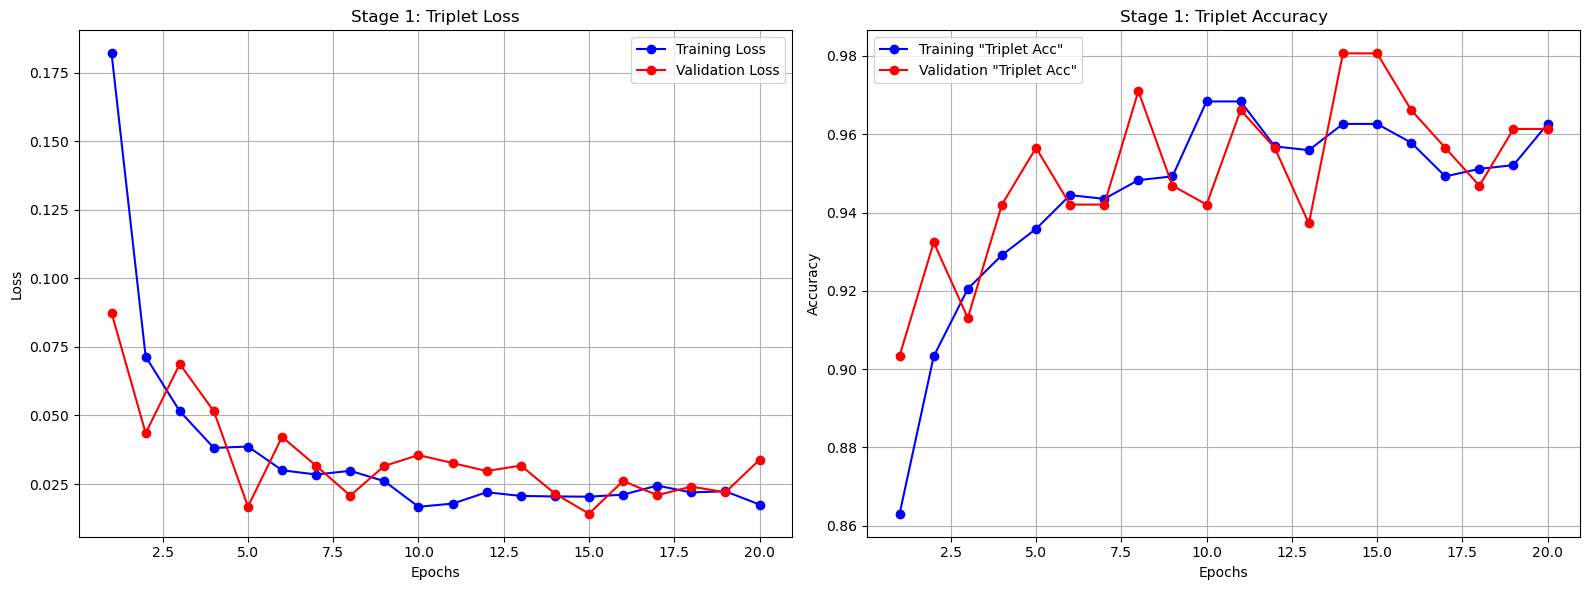

In [41]:
# Create a list of epoch numbers
epochs = range(1, len(history_train_loss) + 1)

plt.figure(figsize=(16, 6))

# Plot 1: Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, history_val_loss, 'r-o', label='Validation Loss')
plt.title('Stage 1: Triplet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Training & Validation "Triplet Accuracy"
plt.subplot(1, 2, 2)
plt.plot(epochs, history_train_acc, 'b-o', label='Training "Triplet Acc"')
plt.plot(epochs, history_val_acc, 'r-o', label='Validation "Triplet Acc"')
plt.title('Stage 1: Triplet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
# --- 1. Define Classification Dataset ---
# This is the dataset from your 2.ipynb, using the correct label_map
class PlantClassifierDataset(Dataset):
    def __init__(self, txt_file, img_dir, label_map, transform, is_test=False, label_file=None):
        self.is_test = is_test
        self.img_data = pd.read_csv(txt_file, sep=' ', header=None)
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        
        if label_file: # Load labels from a separate file (e.g., groundtruth.txt)
            self.labels = pd.read_csv(label_file, sep=' ', header=None)[1].values
        elif not is_test: # Load labels from the main file (e.g., train.txt)
            self.labels = self.img_data[1].values
        else: # No labels for the test set
            self.labels = None

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        img_name = self.img_data.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image
        else:
            species_id = int(self.labels[idx])
            label = self.label_map[species_id]
            return image, label

print("PlantClassifierDataset defined.")



PlantClassifierDataset defined.


In [43]:
# --- 2. Create Datasets ---
# We use the FULL training set with augmentations
train_dataset_cls = PlantClassifierDataset(txt_file=TRAIN_LIST_FILE,
                                           img_dir=TRAIN_IMG_DIR,
                                           label_map=label_map,
                                           transform=train_transform, # Use augmentations
                                           is_test=False)

# We use the TEST set as our validation set
val_dataset_cls = PlantClassifierDataset(txt_file=TEST_LIST_FILE,
                                         img_dir=TEST_IMG_DIR,
                                         label_map=label_map,
                                         transform=val_test_transform, # No augmentations
                                         is_test=False,
                                         label_file=TEST_TRUTH_FILE)

# --- ADDED: Create the Test Dataset (for final evaluation) ---
test_dataset = PlantClassifierDataset(txt_file=TEST_LIST_FILE,
                                      img_dir=TEST_IMG_DIR,
                                      label_map=label_map,
                                      transform=val_test_transform,
                                      is_test=True) # is_test=True

# --- ADDED: Calculate Class Weights ---
print("\nCalculating class weights for imbalance...")
all_train_labels = pd.read_csv(TRAIN_LIST_FILE, sep=' ', header=None)[1].map(label_map)
class_counts_series = all_train_labels.value_counts()

full_class_index = np.arange(NUM_CLASSES)
class_counts = class_counts_series.reindex(full_class_index, fill_value=0).sort_index()
counts_plus_one = torch.tensor(class_counts.values, dtype=torch.float) + 1.0
class_weights = 1.0 / counts_plus_one
class_weights = class_weights / class_weights.sum() * NUM_CLASSES
class_weights = class_weights.to(DEVICE)
print(f"Class weights tensor created with {len(class_weights)} entries.")

# --- 3. Create DataLoaders ---
train_loader_cls = DataLoader(train_dataset_cls, batch_size=BATCH_SIZE, shuffle=True)
val_loader_cls = DataLoader(val_dataset_cls, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # <-- ADDED
print(f"Created Classifier DataLoaders: {len(train_loader_cls)} train, {len(val_loader_cls)} val, {len(test_loader)} test batches.")

# --- ADDED: Load and map y_test ---
original_test_labels = pd.read_csv(TEST_TRUTH_FILE, sep=' ', header=None).iloc[:, 1].values
y_test = np.array([label_map[label] for label in original_test_labels])
print(f"y_test (ground truth) labels loaded and mapped to [0-99].")


Calculating class weights for imbalance...
Class weights tensor created with 100 entries.
Created Classifier DataLoaders: 297 train, 13 val, 13 test batches.
y_test (ground truth) labels loaded and mapped to [0-99].


In [44]:
# --- 1. Load the Best Fine-Tuned Backbone ---
print("Loading best fine-tuned BACKBONE...")
# We can just use the 'model' variable from before, 
# but it's safer to reload it from scratch.
classifier_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)
classifier_model.head = nn.Identity() # It's a backbone

# Load the weights we saved in Cell 7
classifier_model.load_state_dict(torch.load(BEST_BACKBONE_PATH, weights_only=True))
print("Best backbone weights loaded.")

# --- 2. Freeze the Backbone ---
print("Freezing backbone parameters...")
for param in classifier_model.parameters():
    param.requires_grad = False

# --- 3. Add New Classifier Head ---
classifier_model.head = nn.Linear(768, NUM_CLASSES)
print(f"Added new nn.Linear(768, {NUM_CLASSES}) head.")
classifier_model = classifier_model.to(DEVICE)

# --- 4. Define NEW Loss and Optimizer ---
# We use the class_weights from Cell 5
loss_fn_cls = nn.CrossEntropyLoss(weight=class_weights)
# We ONLY optimize the new head's parameters
optimizer_cls = optim.AdamW(classifier_model.head.parameters(), lr=LEARNING_RATE_HEAD) 

# --- 5. Training Loop for the Head ---
best_val_acc = 0.0
history_train_loss_cls = []
history_train_acc_cls = []
history_val_loss_cls = []
history_val_acc_cls = []

print("\n--- STAGE 2: Training Classifier Head ---")

for epoch in range(NUM_EPOCHS_HEAD):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS_HEAD} ---")
    
    classifier_model.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in tqdm(train_loader_cls, desc="Training Head"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        outputs = classifier_model(images)
        loss = loss_fn_cls(outputs, labels)
        
        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
        
    train_acc = train_correct.double() / len(train_dataset_cls)
    train_loss = train_loss / len(train_dataset_cls)
    print(f"Classifier Training Loss: {train_loss:.4f} | Training Acc: {train_acc*100:.2f}%")

    classifier_model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_cls, desc="Validating Head"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = classifier_model(images)
            loss = loss_fn_cls(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_acc = val_correct.double() / len(val_dataset_cls)
    val_loss = val_loss / len(val_dataset_cls)
    print(f"Classifier Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc*100:.2f}%")
    
    history_train_loss_cls.append(train_loss)
    history_train_acc_cls.append(train_acc.cpu()) 
    history_val_loss_cls.append(val_loss)
    history_val_acc_cls.append(val_acc.cpu()) 
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(classifier_model.state_dict(), BEST_CLASSIFIER_PATH)
        print(f"*** New best CLASSIFIER saved! Accuracy: {best_val_acc*100:.2f}% ***")

print("\n--- Classifier Training Complete ---")

Loading best fine-tuned BACKBONE...


Using cache found in /home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main


Best backbone weights loaded.
Freezing backbone parameters...
Added new nn.Linear(768, 100) head.

--- STAGE 2: Training Classifier Head ---

--- Epoch 1/20 ---


Training Head: 100%|██████████| 297/297 [06:55<00:00,  1.40s/it]


Classifier Training Loss: 3.3456 | Training Acc: 30.65%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


Classifier Validation Loss: 4.2466 | Validation Acc: 12.56%
*** New best CLASSIFIER saved! Accuracy: 12.56% ***

--- Epoch 2/20 ---


Training Head: 100%|██████████| 297/297 [06:55<00:00,  1.40s/it]


Classifier Training Loss: 2.1388 | Training Acc: 52.04%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 4.1409 | Validation Acc: 17.39%
*** New best CLASSIFIER saved! Accuracy: 17.39% ***

--- Epoch 3/20 ---


Training Head: 100%|██████████| 297/297 [06:55<00:00,  1.40s/it]


Classifier Training Loss: 1.8048 | Training Acc: 57.90%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


Classifier Validation Loss: 4.1005 | Validation Acc: 19.32%
*** New best CLASSIFIER saved! Accuracy: 19.32% ***

--- Epoch 4/20 ---


Training Head: 100%|██████████| 297/297 [06:55<00:00,  1.40s/it]


Classifier Training Loss: 1.6322 | Training Acc: 61.45%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


Classifier Validation Loss: 4.0112 | Validation Acc: 27.54%
*** New best CLASSIFIER saved! Accuracy: 27.54% ***

--- Epoch 5/20 ---


Training Head: 100%|██████████| 297/297 [06:55<00:00,  1.40s/it]


Classifier Training Loss: 1.5194 | Training Acc: 65.07%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


Classifier Validation Loss: 3.8491 | Validation Acc: 28.50%
*** New best CLASSIFIER saved! Accuracy: 28.50% ***

--- Epoch 6/20 ---


Training Head: 100%|██████████| 297/297 [06:58<00:00,  1.41s/it]


Classifier Training Loss: 1.4109 | Training Acc: 67.73%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Classifier Validation Loss: 3.7687 | Validation Acc: 32.37%
*** New best CLASSIFIER saved! Accuracy: 32.37% ***

--- Epoch 7/20 ---


Training Head: 100%|██████████| 297/297 [06:56<00:00,  1.40s/it]


Classifier Training Loss: 1.3525 | Training Acc: 68.42%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.7255 | Validation Acc: 34.30%
*** New best CLASSIFIER saved! Accuracy: 34.30% ***

--- Epoch 8/20 ---


Training Head: 100%|██████████| 297/297 [06:56<00:00,  1.40s/it]


Classifier Training Loss: 1.2837 | Training Acc: 69.94%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.6953 | Validation Acc: 39.61%
*** New best CLASSIFIER saved! Accuracy: 39.61% ***

--- Epoch 9/20 ---


Training Head: 100%|██████████| 297/297 [06:56<00:00,  1.40s/it]


Classifier Training Loss: 1.2415 | Training Acc: 70.59%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.6473 | Validation Acc: 32.85%

--- Epoch 10/20 ---


Training Head: 100%|██████████| 297/297 [06:56<00:00,  1.40s/it]


Classifier Training Loss: 1.1780 | Training Acc: 71.96%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.6416 | Validation Acc: 39.13%

--- Epoch 11/20 ---


Training Head: 100%|██████████| 297/297 [06:56<00:00,  1.40s/it]


Classifier Training Loss: 1.1442 | Training Acc: 72.26%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.5404 | Validation Acc: 39.13%

--- Epoch 12/20 ---


Training Head: 100%|██████████| 297/297 [06:55<00:00,  1.40s/it]


Classifier Training Loss: 1.1140 | Training Acc: 72.77%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.4674 | Validation Acc: 39.61%

--- Epoch 13/20 ---


Training Head: 100%|██████████| 297/297 [06:56<00:00,  1.40s/it]


Classifier Training Loss: 1.0983 | Training Acc: 72.89%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.4079 | Validation Acc: 44.93%
*** New best CLASSIFIER saved! Accuracy: 44.93% ***

--- Epoch 14/20 ---


Training Head: 100%|██████████| 297/297 [06:55<00:00,  1.40s/it]


Classifier Training Loss: 1.0451 | Training Acc: 74.79%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.4667 | Validation Acc: 42.51%

--- Epoch 15/20 ---


Training Head: 100%|██████████| 297/297 [06:56<00:00,  1.40s/it]


Classifier Training Loss: 1.0280 | Training Acc: 75.91%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Classifier Validation Loss: 3.4314 | Validation Acc: 43.48%

--- Epoch 16/20 ---


Training Head: 100%|██████████| 297/297 [06:57<00:00,  1.40s/it]


Classifier Training Loss: 0.9914 | Training Acc: 75.36%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.4943 | Validation Acc: 40.10%

--- Epoch 17/20 ---


Training Head: 100%|██████████| 297/297 [06:57<00:00,  1.41s/it]


Classifier Training Loss: 0.9501 | Training Acc: 76.92%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.4706 | Validation Acc: 44.93%

--- Epoch 18/20 ---


Training Head: 100%|██████████| 297/297 [06:56<00:00,  1.40s/it]


Classifier Training Loss: 0.9588 | Training Acc: 77.02%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.3863 | Validation Acc: 44.93%

--- Epoch 19/20 ---


Training Head: 100%|██████████| 297/297 [06:55<00:00,  1.40s/it]


Classifier Training Loss: 0.9137 | Training Acc: 77.68%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Classifier Validation Loss: 3.3533 | Validation Acc: 45.41%
*** New best CLASSIFIER saved! Accuracy: 45.41% ***

--- Epoch 20/20 ---


Training Head: 100%|██████████| 297/297 [06:56<00:00,  1.40s/it]


Classifier Training Loss: 0.8920 | Training Acc: 78.58%


Validating Head: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]

Classifier Validation Loss: 3.3793 | Validation Acc: 44.44%

--- Classifier Training Complete ---


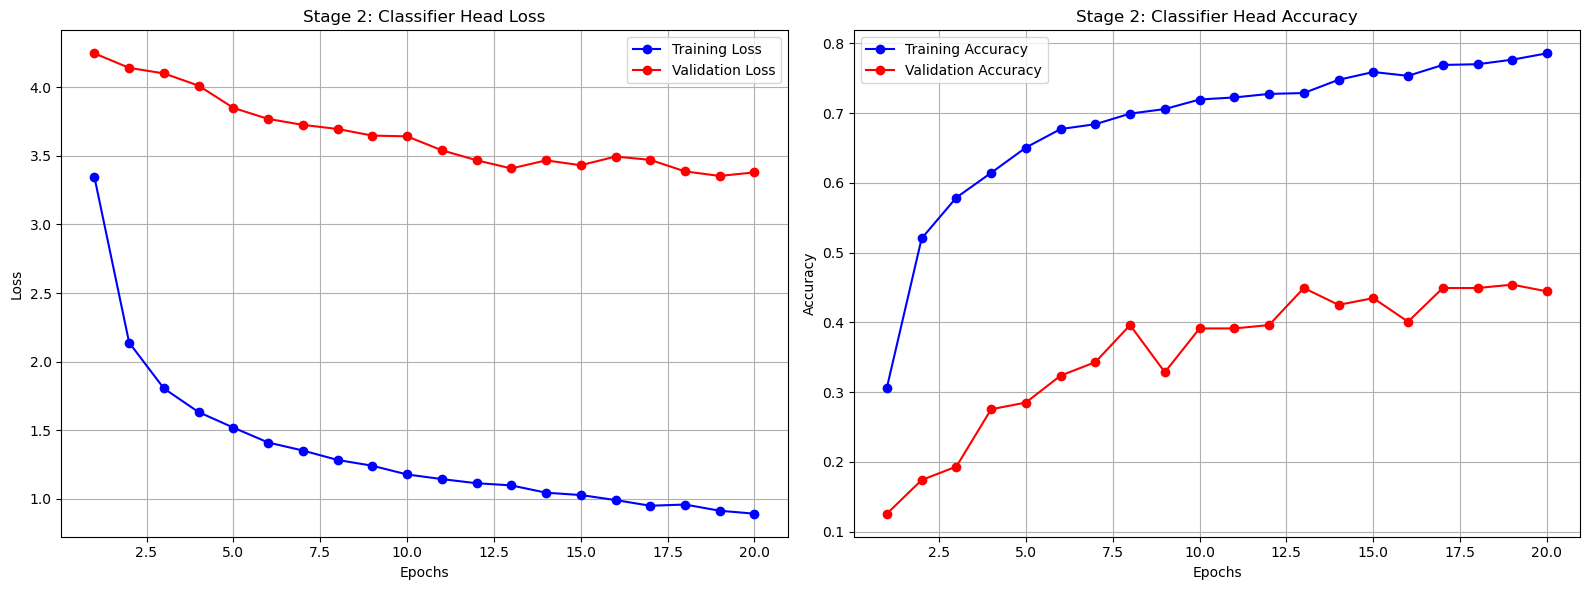

In [45]:
epochs_cls = range(1, len(history_train_loss_cls) + 1)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_cls, history_train_loss_cls, 'b-o', label='Training Loss')
plt.plot(epochs_cls, history_val_loss_cls, 'r-o', label='Validation Loss')
plt.title('Stage 2: Classifier Head Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_cls, history_train_acc_cls, 'b-o', label='Training Accuracy')
plt.plot(epochs_cls, history_val_acc_cls, 'r-o', label='Validation Accuracy')
plt.title('Stage 2: Classifier Head Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

In [46]:
# --- 1. Load the Best FULL Model (Backbone + Head) ---
print("Loading best fine-tuned CLASSIFIER model for final evaluation...")
# Create a new instance of the model architecture
eval_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)
eval_model.head = nn.Linear(768, NUM_CLASSES)

# Load the saved classifier weights
eval_model.load_state_dict(torch.load(BEST_CLASSIFIER_PATH, weights_only=True))
eval_model = eval_model.to(DEVICE)
eval_model.eval() 
print("Best classifier model loaded.")

# --- 2. Evaluate on Test Set ---
all_predictions = []
with torch.no_grad():
    for images in tqdm(test_loader, desc="Evaluating on Test Set"):
        images = images.to(DEVICE)
        outputs = eval_model(images)
        all_predictions.append(outputs.cpu())

y_pred_probas = torch.cat(all_predictions, dim=0)
y_pred_top1 = torch.argmax(y_pred_probas, dim=1).numpy()
print("Evaluation complete.")

# --- 3. Calculate Final Metrics ---
all_class_labels = np.arange(NUM_CLASSES)
top1_acc = accuracy_score(y_test, y_pred_top1)
top5_acc = top_k_accuracy_score(y_test, y_pred_probas.numpy(), k=5, labels=all_class_labels)

print(f"\n--- New Approach (Triplet + Classifier) Results ---")
print(f"  Top-1 Accuracy: {top1_acc * 100:.2f}%")
print(f"  Top-5 Accuracy: {top5_acc * 100:.2f}%")

Loading best fine-tuned CLASSIFIER model for final evaluation...


Using cache found in /home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main


Best classifier model loaded.


Evaluating on Test Set: 100%|██████████| 13/13 [00:47<00:00,  3.67s/it]

Evaluation complete.

--- New Approach (Triplet + Classifier) Results ---
  Top-1 Accuracy: 45.41%
  Top-5 Accuracy: 64.73%


Generating confusion matrix...


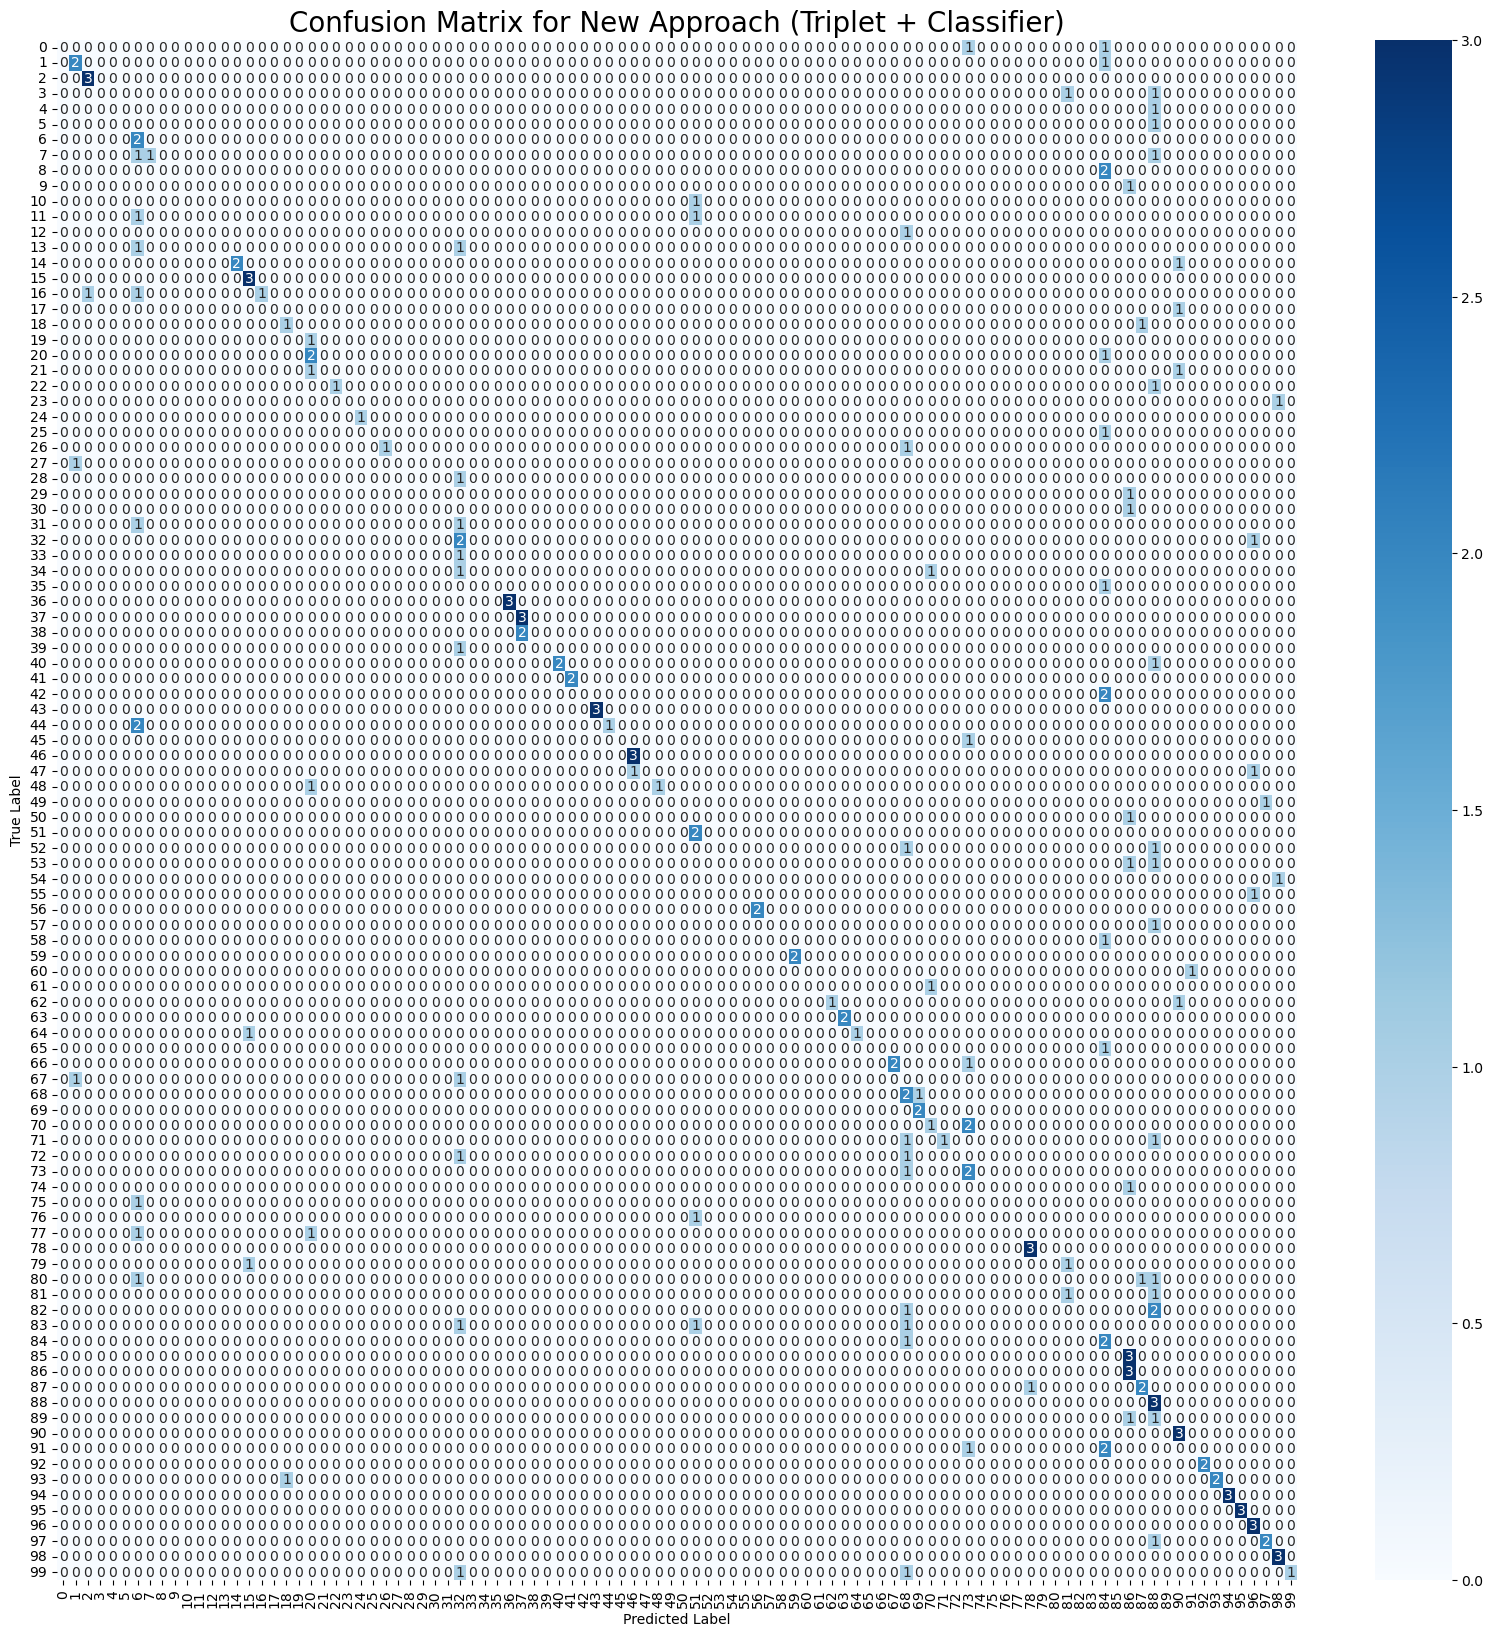


--- Analysis of Performance by Class Type ---

Group: WITH PAIRS (Trained on Herbarium + Field)
  Top-1 Accuracy: 60.78%
  Top-5 Accuracy: 86.93%

Group: WITHOUT PAIRS (Trained on Herbarium ONLY)
  Top-1 Accuracy: 1.85%
  Top-5 Accuracy: 1.85%


/home/wongxuanyong/miniconda3/envs/aml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/home/wongxuanyong/miniconda3/envs/aml_project/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1998: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_type = type_of_target(y_true, input_name="y_true")


In [47]:
# --- Plot Confusion Matrix ---
print("Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_top1)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=all_class_labels, yticklabels=all_class_labels)
plt.title('Confusion Matrix for New Approach (Triplet + Classifier)', fontsize=20)
plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.show()

# --- Analysis by Class Type ---
print("\n--- Analysis of Performance by Class Type ---")
with_pairs_ids = set(pd.read_csv(WITH_PAIRS_FILE, header=None).iloc[:, 0])
without_pairs_ids = set(pd.read_csv(WITHOUT_PAIRS_FILE, header=None).iloc[:, 0])
with_pairs_set = {label_map.get(id, -1) for id in with_pairs_ids}
without_pairs_set = {label_map.get(id, -1) for id in without_pairs_ids}

test_with_pairs_indices = [i for i, label in enumerate(y_test) if label in with_pairs_set]
test_without_pairs_indices = [i for i, label in enumerate(y_test) if label in without_pairs_set]

y_test_with_pairs = y_test[test_with_pairs_indices]
y_pred_top1_with_pairs = y_pred_top1[test_with_pairs_indices]
y_probas_with_pairs = y_pred_probas.numpy()[test_with_pairs_indices]
y_test_without_pairs = y_test[test_without_pairs_indices]
y_pred_top1_without_pairs = y_pred_top1[test_without_pairs_indices]
y_probas_without_pairs = y_pred_probas.numpy()[test_without_pairs_indices]

acc_top1_with = accuracy_score(y_test_with_pairs, y_pred_top1_with_pairs)
acc_top5_with = top_k_accuracy_score(y_test_with_pairs, y_probas_with_pairs, k=5, labels=all_class_labels)
acc_top1_without = accuracy_score(y_test_without_pairs, y_pred_top1_without_pairs)
acc_top5_without = top_k_accuracy_score(y_test_without_pairs, y_probas_without_pairs, k=5, labels=all_class_labels)

print(f"\nGroup: WITH PAIRS (Trained on Herbarium + Field)")
print(f"  Top-1 Accuracy: {acc_top1_with * 100:.2f}%")
print(f"  Top-5 Accuracy: {acc_top5_with * 100:.2f}%")
print(f"\nGroup: WITHOUT PAIRS (Trained on Herbarium ONLY)")
print(f"  Top-1 Accuracy: {acc_top1_without * 100:.2f}%")
print(f"  Top-5 Accuracy: {acc_top5_without * 100:.2f}%")